## Partial Correlation

**Christian Gerloff**

**Keywords:** multiple regression, confounding, causality, matrix decomposition

### Intoduction


given a data set $S= \{X,Y,Z\}$ containing multiple continuous variables we are interested in analysing the strength of a linear relationship between them


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pingouin import partial_corr

np.random.seed(1337)
df = pd.DataFrame()
df['Emotionregulation'] = np.random.randint(1, 10, size=100)
df['Openness'] = np.random.randint(1, 10, size=100)
df['Age'] = np.random.randint(18, 70, size=100)
df.head()

,Emotionregulation,Openness,Age
0,8,5,42
1,9,2,47
2,8,1,63
3,8,8,45
4,3,8,61


We can do this by calculating pairwise the correlation coefficients by:

$ Corr = \begin{bmatrix} 
\rho_{x,x} = \frac{\text{cov}(X,X)}{\sigma_x \sigma_x} &
\rho_{x,y} = \frac{\text{cov}(X,Y)}{\sigma_x \sigma_y} &
\rho_{x,z} = \frac{\text{cov}(X,Z)}{\sigma_x \sigma_z} \\
\rho_{y,x} = \frac{\text{cov}(Y,X)}{\sigma_y \sigma_x} &
\rho_{y,y} = \frac{\text{cov}(Y,Y)}{\sigma_y \sigma_y} &
\rho_{y,z} = \frac{\text{cov}(Y,Z)}{\sigma_y \sigma_z} \\
\rho_{z,x} = \frac{\text{cov}(Z,X)}{\sigma_z \sigma_x} &
\rho_{z,y} = \frac{\text{cov}(Z,Y)}{\sigma_z \sigma_y} &
\rho_{z,z} = \frac{\text{cov}(Z,Z)}{\sigma_z \sigma_z}
\end{bmatrix}$

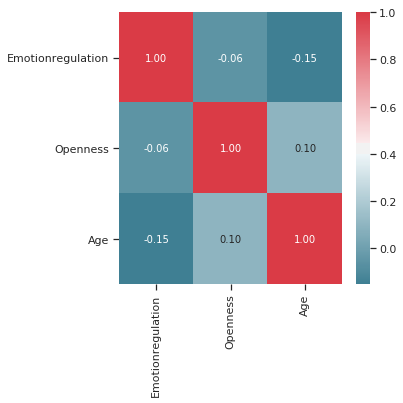

In [2]:
def heatMap(cov_mat, mirror = True):
    
    fig, ax = plt.subplots(figsize=(5, 5))
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    if mirror == True:
        # Allow annotations and place floats in map
        sns.heatmap(cov_mat, cmap=colormap, annot=True, fmt=".2f")
        plt.show()

    else:
        # Drop self-correlations
        dropSelf = np.zeros_like(cov_mat)
        # set diag off set to 1 to include diag
        dropSelf[np.triu_indices_from(dropSelf, k = 1)] = True
        sns.heatmap(cov_mat, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf)
    
    plt.show()
pearson = df.corr()
heatMap(pearson)

Now, we want to take into account conditions:

![alt text](images/confounds.png "confounds")

Let's bring together the off-diag. coefficients with the condition reprsented in the **path-diagram** use these coefficients to calculate conditioned on an factor the partial correlation given by the formular:
$\rho_{Y,Z|X} = \frac{\rho_{Y,Z} - \rho_{X,Y} \rho_{Z,X}}{\sqrt{\left( 1-\rho^{2}_{X,Y} \right) \left( 1 - \rho^{2}_{Z,X} \right) }} =  \frac{0.1-0.06*0.15}{\sqrt{\left( 1-0.06^{2} \right)\left( 1 - 0.15^{2} \right) }} = 0.09$
    
    


In [3]:
partial_corr(data=df, x='Openness', y='Age', covar='Emotionregulation')

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,100,0.09,"[-0.11, 0.28]",0.008,-0.012,0.372732,0.117,0.145


### Takeaways
* If you want to measure data with different levels on scales:

* the definition of the part.corr relies on the concentration matrix of a covariance matrix
  so you can use other correlation measures such as spearman


* is zero if and only if X is conditionally independent from Y given Z.

**Underestimated Complexity:** You may not be measuring all confounders. Either because you're not even aware of some, or because you're aware of them but genuinely can't measure their values.

**Overestimated Complexity:** You may be controlling for too much. When one wants to make sure all confounders are covered, it's common to simply control for all observable variables, in case they turn out to be confounders.


## Comparision multiple Linear regression and partial correlation

We described above a multiple regression setting. Consequently, the regression coefficient in multiple regression is ~ partial correlation. The difference just comes from the standardization:

$\beta_{Y,Z|X} = \rho_{Y,Z|X} \frac{\sigma_{X,Y}}{ \sigma_{Z,X}} $

So partial correlation is implemented (and it is rare in python) i is just done by fitting a linear regression
by:

    1) perform a normal linear least-squares regression with Y as the target and X as the predictor
    2) calculate the residuals in Step #1
    3) perform a normal linear least-squares regression with Z as the target and X as the predictor
    4) calculate the residuals in Step #3
    5) calculate the correlation coefficient between the residuals from Steps #2 and #4; 
    The result is the partial correlation between Y and Z while controlling for the effect of X
    
    (see http://en.wikipedia.org/wiki/Partial_correlation#Using_linear_regression

ok, so it's often achieved via regression but can we calculate it in another way?

###  Use the power of linear algebra

**Can be calculated by cov mat:** by calculating the inverse of this matrix, also termed **concentration or precision matrix** denoted by $C$, we archive a matrix which:

 * diagonal elements describe how tightly an isolated variable occurs around the mean,
 * off-diag. elements are representing **to which extend a variable do not correlate/co-vary with the other variables**, 
 * sparsity (we love sparse matrices ;))
 
So conditioning on holding const. all other variables, each off-diag coefficient $-c_{i,j}$ represents the partial covariance between $i$ and $j$. From this, we can easily calculate the partial correlation


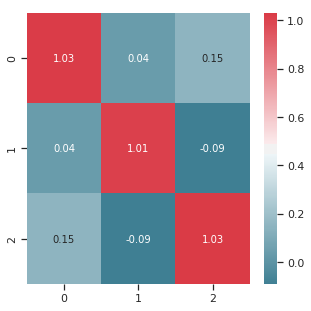

In [4]:
concentration_matrix = np.linalg.inv(pearson)
heatMap(concentration_matrix)

cool! $\rho_{Y,Z|X} = -c_{2,1}$=0.09

### Cholesky Decomposition

Inverse problems are often computational expensive so python uses matrix decomposition to simplify matrix operations, let's use Cholesky Decomposition to improve our previous example.

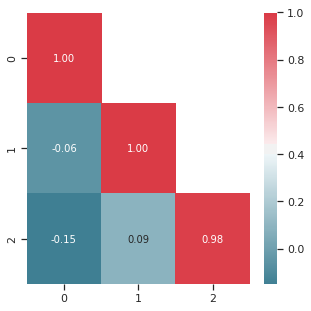

In [5]:
#https://www.quantstart.com/articles/Cholesky-Decomposition-in-Python-and-NumPys
L = np.linalg.cholesky(pearson)
heatMap(L, False)

$\rho_{Y,Z|X} = 1*0.09$

L can be used to obtain the "regression" coefficients

$ L_{X,Y} = \begin{bmatrix}
    1 &
    . & \\
    L_{1,0} &
    L_{1,1}
\end{bmatrix}$

In [6]:
M = np.linalg.inv(L[0:2,0:2])
M = np.hstack([M, [[0],[0]]])
M = np.append(M, [[0,0,1]], axis=0)
beta = np.dot(L, M)
print(beta)

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 3.63688296e-18  1.00000000e+00  0.00000000e+00]
 [-1.45750651e-01  8.91989322e-02  9.84551341e-01]]


### Summary Partial Correlation:

* it is a process measuring the strength and also the direction of a linear relationship
* is measured between **continuous variables** via a defined correlation 
* accounts for **confounding** / other potential, influential continuous variables (termed 'covariates')
* leads to the same results / p-values as the multiple regression coefficients
* can be efficiently implemented via matrix decomposition or regression
* can be used to illuminate the emergence of several phenomena in causal analysis such as Simpson paradox but is restricted to homogeneous populations with no interactions.


## References

### Partial Correlation

Judea Pearl, Linear Models: A Useful “Microscope” for Causal Analysis:


implementation in python (via regression):
https://gist.github.com/fabianp/9396204419c7b638d38f


### Matrix Decomposition

Gilbert Strange, "Introduction to Linear Algebra":
* http://math.mit.edu/~gs/linearalgebra/
    
* https://elf-c.he.u-tokyo.ac.jp/courses/110

Gene H. Golub and Charles Van Loan, "Matrix Computations"
    
Pratical Examples Matrix Decomposition:

* https://people.duke.edu/~ccc14/sta-663/LinearAlgebraMatrixDecompWithSolutions.html
* https://www.quantstart.com/articles/Cholesky-Decomposition-in-Python-and-NumPy